In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
     |████████████████████████████████| 195.4 MB 1.2 kB/s eta 0:00:014  |█                               | 5.6 MB 551 kB/s eta 0:05:45     |█▊                              | 10.4 MB 989 kB/s eta 0:03:07     |██                              | 11.7 MB 367 kB/s eta 0:08:20     |██▉                             | 17.3 MB 705 kB/s eta 0:04:13     |███▊                            | 22.7 MB 2.8 MB/s eta 0:01:02     |████▏                           | 25.2 MB 850 kB/s eta 0:03:21     |██████▋                         | 40.1 MB 1.9 MB/s eta 0:01:21     |████████▎                       | 50.2 MB 3.3 MB/s eta 0:00:45     |████████▊                       | 53.0 MB 834 kB/s eta 0:02:51     |█████████                       | 55.6 MB 822 kB/s eta 0:02:50 MB 822 kB/s eta 0:02:47��████▎                     | 62.6 MB 651 kB/s eta 0:03:24kB/s eta 0:02:54     |██████████████▍                 | 88.1 MB 745 kB/s eta 0:02:24     |███████████████▏         

In [3]:
import os
import shutil
import posixpath
import time

import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import TensorDataset, Dataset
import torch.nn as nn

In [19]:
MOUNTPATH = '/mount'
DATAPATH = MOUNTPATH + '/data' 
MIMICPATH = DATAPATH + '/mimic3/mimic-iii-clinical-database-1.4'
DEMOPATH = DATAPATH + '/mimic3/mimic-iii-clinical-database-demo-1.4'
WAVEFPATH = DATAPATH + '/waveform/physionet.org/files/mimic3wdb-matched/1.0'
def get_waveform_path(patientid, recordid):
    return WAVEFPATH + f'/{patientid[0:3]}/{patientid}/{recordid}'
CHANNEL_NAMES = ['HR','RESP','PULSE','etco2', 'SpO2', 'CVP','AWRR', 'NBP Mean',  'NBP Dias',   'NBP Sys']
OUTPUTPATH = MOUNTPATH + '/model' 

{'record_name': 'p044083-2112-05-04-19-50n',
 'n_sig': 7,
 'fs': 1,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 164919,
 'base_time': datetime.time(19, 50, 40),
 'base_date': datetime.date(2112, 5, 4),
 'comments': ['Location: micu/sicu'],
 'sig_name': ['HR',
  'RESP',
  'PULSE',
  'SpO2',
  'NBP Mean',
  'NBP Dias',
  'NBP Sys'],
 'p_signal': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['3314767n.dat',
  '3314767n.dat',
  '3314767n.dat',
  '3314767n.dat',
  '3314767n.dat',
  '3314767n.dat',
  '3314767n.dat'],
 'fmt': ['16', '16', '16', '16', '16', '16', '16'],
 'samps_per_frame': [1, 1, 1, 1, 1, 1, 1],
 'skew': [None, None, None, None, None, None, None],
 'byte_

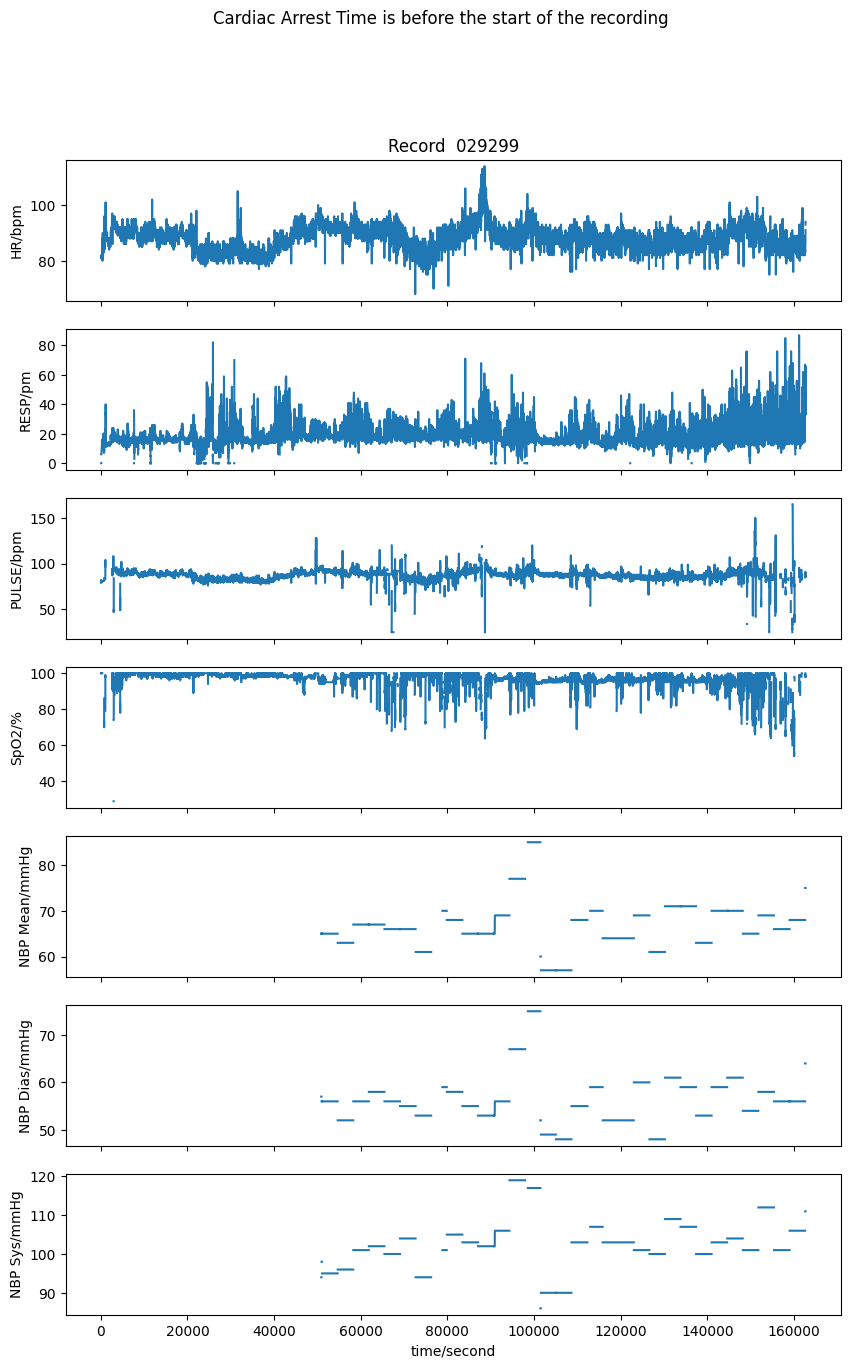

In [5]:
# This is a patient with cardiac arrest

patient_path = get_waveform_path('p044083', 'p044083-2112-05-04-19-50n')

# select only HR from patient path using wfdb
record = wfdb.rdrecord(patient_path, channel_names=CHANNEL_NAMES)
# record = wfdb.rdrecord(patient_path) 

# wfdb.plot_wfdb(record=record, title='Record  029299') 
# increase the size of the plot please
# wfdb.plot_wfdb(record=record, title='Record  029299', figsize=(10,15))

# Select only HR from the plots, not with the channels parameter
fig = wfdb.plot_wfdb(record=record, title='Record  029299', figsize=(10,15), return_fig=True)
ax_list = fig.axes

import datetime 

base_time = datetime.datetime.combine(record.__dict__['base_date'], 
                          record.__dict__['base_time'])

# Create datetime using strptime
ca_time = datetime.datetime.strptime('2112-05-04 04:38:00', '%Y-%m-%d %H:%M:%S')

# find time delta between base_time and ca_time
# Convert it to an int that represents the number of seconds
time_delta = int((ca_time - base_time).total_seconds())

# Plot a vertical line at time_delta
if time_delta > 0:
    for ax in ax_list:
        ax.axvline(x=time_delta, color='red', linestyle='--',)
else:
    # change title of fig
    fig.suptitle('Cardiac Arrest Time is before the start of the recording')

fig.show()

display(record.__dict__)

In [6]:
record_df = record.to_dataframe()
record_df = record_df.interpolate(method='linear').fillna(0)

# We take ten minutes of data with 1 minute of sliding window
record_df = record_df.iloc[::5, :]

# Which means that each should have 120 records
record_arr = np.stack([record_df.iloc[i:i+int(600/5), :].values for i in range(0, len(record_df)-int(600/5), int(60/5))])
record_arr.shape

(2739, 120, 7)

In [7]:
record_arr = record_arr.reshape(2739, 7, 120)
record_arr

array([[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,  82.        ],
        [  0.        ,  81.        , 100.        , ...,   0.        ,
          82.        ,   6.        ],
        [ 81.        , 100.        ,   0.        , ...,  81.        ,
          11.        ,  81.        ],
        ...,
        [  0.        ,   0.        ,   0.        , ...,  81.        ,
          94.63741339,   0.        ],
        [  0.        ,   0.        ,  81.        , ...,  89.33718245,
           0.        ,   0.        ],
        [  0.        ,  82.        ,  10.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[  0.        ,   0.        ,  80.        , ...,   0.        ,
           0.        ,  82.        ],
        [  4.2       ,  81.        , 100.        , ...,   0.        ,
          81.        ,  11.        ],
        [ 81.        , 100.        ,   0.        , ...,  81.        ,
          11.        ,  80.        ],
        ...,


In [8]:
x = record_arr
record_df['y']=1
y = record_df['y'].astype(np.float32).values
y = np.random.randint(low=0, high=2, size=record_arr.shape[0]).squeeze()
# y = torch.randint(2, size=(record_arr.shape[0],))
y.shape

(2739,)

TypeError: isnan(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [9]:
x.shape

(2739, 7, 120)

In [10]:


def load_dataset(x,y):
	"""
	:param path: a path to the seizure data CSV file
	:return dataset: a TensorDataset consists of a data Tensor and a target Tensor
	"""
	# Casting in pytorch tensor
	data = torch.from_numpy(x).type(torch.FloatTensor)
	target = torch.from_numpy(y).type(torch.LongTensor)

	# x[torch.isnan(x)] = 0

	# Need to be of size (N, Cn, L)
	# N: batch size
	# Cn: number of channels
	# L: length of the sequence
	data = data.reshape((data.shape[0], data.shape[1], data.shape[2]))
	dataset = TensorDataset(data, target.long())

	return dataset


In [11]:
class MyCNN(nn.Module):
	
	def __init__(self):
		# self.MAGIC_NUMBER = 16*41
		super(MyCNN, self).__init__()
		self.conv1 = nn.Conv1d(in_channels=7, out_channels=4, kernel_size=5)
		self.conv2 = nn.Conv1d(in_channels=4, out_channels=1, kernel_size=5)
		self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
		# self.out = nn.Linear(in_features=567, out_features=1)

		self.dropout = nn.Dropout(0.5)
		self.lstm = nn.LSTM(input_size = 27, hidden_size=16, num_layers=2)
		self.out = nn.Linear(in_features=16, out_features=2)

	def forward(self, x):
		x = torch.tanh(self.conv1(x))
		x = self.pool(x)
		x = torch.tanh(self.conv2(x))
		x = self.pool(x)
		x = self.dropout(x)
		x = x.view(-1, 27)
		x,_ = self.lstm(x)
		x = self.out(x)
		# x = self.out(x)
		return x


In [13]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

from utils import train, evaluate
# from plots import plot_learning_curves, plot_confusion_matrix

#TODO: https://pytorch.org/docs/stable/notes/windows.html#multiprocessing-error-without-if-clause-protection

# # Set a correct path to the seizure data file you downloaded
# PATH_TRAIN_FILE = "../data/seizure/seizure_train.csv"
# PATH_VALID_FILE = "../data/seizure/seizure_validation.csv"
# PATH_TEST_FILE = "../data/seizure/seizure_test.csv"

# # Path for saving model
# PATH_OUTPUT = "../output/seizure/"
# os.makedirs(PATH_OUTPUT, exist_ok=True)

# # Some parameters
# MODEL_TYPE = 'MLP'  # TODO: Change this to 'MLP', 'CNN', or 'RNN' according to your task
NUM_EPOCHS = 10
BATCH_SIZE = 32
USE_CUDA = False  # Set 'True' if you want to use GPU
NUM_WORKERS = 0  # Number of threads used by DataLoader. You can adjust this according to your machine spec.

model = MyCNN()
save_file = 'MyCNN2.pth'

device = torch.device("cuda" if USE_CUDA and torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
if device.type == "cuda":
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

# train_dataset = load_seizure_dataset(PATH_TRAIN_FILE, MODEL_TYPE)
# valid_dataset = load_seizure_dataset(PATH_VALID_FILE, MODEL_TYPE)
# test_dataset = load_seizure_dataset(PATH_TEST_FILE, MODEL_TYPE)
train_dataset = load_dataset(x[0:1000],y[0:1000])
valid_dataset = load_dataset(x[1000:1500],y[1000:1500])
test_dataset = load_dataset(x[1500:],y[1500:])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model Summary: {pytorch_total_params}")

# Delete me
def count_parameters(model):
    # table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        print(f"{name}: {params}")
        total_params+=params
    # print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

best_val_acc = 0.0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(NUM_EPOCHS):
	train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch)
	valid_loss, valid_accuracy, valid_results = evaluate(model, device, valid_loader, criterion)

	train_losses.append(train_loss)
	valid_losses.append(valid_loss)

	train_accuracies.append(train_accuracy)
	valid_accuracies.append(valid_accuracy)

	is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
	if is_best:
		best_val_acc = valid_accuracy
		torch.save(model, os.path.join(OUTPUTPATH, save_file), _use_new_zipfile_serialization=False)

# plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)

best_model = torch.load(os.path.join(PATH_OUTPUT, save_file))
test_loss, test_accuracy, test_results = evaluate(best_model, device, test_loader, criterion)

# class_names = ['Seizure', 'TumorArea', 'HealthyArea', 'EyesClosed', 'EyesOpen']
# plot_confusion_matrix(test_results, class_names)


Model Summary: 5255
conv1.weight: 140
conv1.bias: 4
conv2.weight: 20
conv2.bias: 1
lstm.weight_ih_l0: 1728
lstm.weight_hh_l0: 1024
lstm.bias_ih_l0: 64
lstm.bias_hh_l0: 64
lstm.weight_ih_l1: 1024
lstm.weight_hh_l1: 1024
lstm.bias_ih_l1: 64
lstm.bias_hh_l1: 64
out.weight: 32
out.bias: 2
Total Trainable Params: 5255
Epoch: [0][0/32]	Time 0.792 (0.792)	Data 0.028 (0.028)	Loss 0.8026 (0.8026)	Accuracy 37.500 (37.500)
Epoch: [0][10/32]	Time 0.004 (0.081)	Data 0.001 (0.004)	Loss 0.7118 (0.7404)	Accuracy 53.125 (48.295)
Epoch: [0][20/32]	Time 0.020 (0.059)	Data 0.000 (0.003)	Loss 0.7275 (0.7337)	Accuracy 50.000 (49.256)
Epoch: [0][30/32]	Time 0.005 (0.058)	Data 0.001 (0.003)	Loss 0.7705 (0.7367)	Accuracy 40.625 (48.387)
Test: [0/16]	Time 0.228 (0.228)	Loss 0.6144 (0.6144)	Accuracy 71.875 (71.875)
Test: [10/16]	Time 0.002 (0.044)	Loss 0.7700 (0.7237)	Accuracy 40.625 (50.000)


/usr/local/lib/python3.9/site-packages/torch/serialization.py:474: UserWarning: Couldn't retrieve source code for container of type MyCNN. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


Epoch: [1][0/32]	Time 0.228 (0.228)	Data 0.001 (0.001)	Loss 0.6934 (0.6934)	Accuracy 56.250 (56.250)
Epoch: [1][10/32]	Time 0.003 (0.117)	Data 0.000 (0.003)	Loss 0.7215 (0.7296)	Accuracy 50.000 (48.580)
Epoch: [1][20/32]	Time 0.013 (0.066)	Data 0.000 (0.002)	Loss 0.6767 (0.7298)	Accuracy 59.375 (48.363)
Epoch: [1][30/32]	Time 0.184 (0.078)	Data 0.000 (0.003)	Loss 0.7049 (0.7288)	Accuracy 53.125 (48.387)
Test: [0/16]	Time 0.010 (0.010)	Loss 0.6181 (0.6181)	Accuracy 71.875 (71.875)
Test: [10/16]	Time 0.001 (0.004)	Loss 0.7634 (0.7197)	Accuracy 40.625 (50.000)
Epoch: [2][0/32]	Time 0.006 (0.006)	Data 0.001 (0.001)	Loss 0.7180 (0.7180)	Accuracy 50.000 (50.000)
Epoch: [2][10/32]	Time 0.004 (0.030)	Data 0.000 (0.001)	Loss 0.7027 (0.7165)	Accuracy 53.125 (50.284)
Epoch: [2][20/32]	Time 0.014 (0.038)	Data 0.001 (0.002)	Loss 0.7023 (0.7250)	Accuracy 53.125 (48.214)
Epoch: [2][30/32]	Time 0.004 (0.042)	Data 0.001 (0.002)	Loss 0.7019 (0.7235)	Accuracy 53.125 (48.387)
Test: [0/16]	Time 0.002 (0.00

In [24]:
model = torch.load(OUTPUTPATH+'/MyCNN2.pth')
test_dataset = load_dataset(x[1500:],y[1500:])
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1600, shuffle=False, num_workers=NUM_WORKERS)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if USE_CUDA and torch.cuda.is_available() else "cpu")
evaluate(model, device, test_loader, criterion, print_freq=10)

Test: [0/1]	Time 0.022 (0.022)	Loss 0.7322 (0.7322)	Accuracy 48.400 (48.400)


(0.7322310209274292,
 48.400001525878906,
 [(0, 1),
  (0, 1),
  (0, 1),
  (1, 1),
  (1, 1),
  (1, 1),
  (0, 1),
  (0, 1),
  (1, 1),
  (1, 1),
  (1, 1),
  (1, 1),
  (1, 1),
  (0, 1),
  (0, 1),
  (0, 1),
  (0, 1),
  (0, 1),
  (1, 1),
  (1, 1),
  (1, 1),
  (0, 1),
  (1, 1),
  (1, 1),
  (1, 1),
  (0, 1),
  (0, 1),
  (0, 1),
  (1, 1),
  (0, 1),
  (1, 1),
  (0, 1),
  (1, 1),
  (1, 1),
  (0, 1),
  (0, 1),
  (0, 1),
  (1, 1),
  (1, 1),
  (0, 1),
  (0, 1),
  (0, 1),
  (1, 1),
  (0, 1),
  (1, 1),
  (0, 1),
  (1, 1),
  (1, 1),
  (0, 1),
  (0, 1),
  (0, 1),
  (1, 1),
  (1, 1),
  (1, 1),
  (0, 1),
  (1, 1),
  (1, 1),
  (0, 1),
  (1, 1),
  (1, 1),
  (1, 1),
  (0, 1),
  (1, 1),
  (0, 1),
  (1, 1),
  (0, 1),
  (1, 1),
  (1, 1),
  (1, 1),
  (1, 1),
  (1, 1),
  (0, 1),
  (1, 1),
  (0, 1),
  (1, 1),
  (1, 1),
  (1, 1),
  (1, 1),
  (1, 1),
  (1, 1),
  (1, 1),
  (0, 1),
  (1, 1),
  (1, 1),
  (0, 1),
  (1, 1),
  (0, 1),
  (1, 1),
  (0, 1),
  (0, 1),
  (0, 1),
  (1, 1),
  (0, 1),
  (0, 1),
  (1, 1),
  (1, 1)